# Experiments with condVAE: Paul15 dataset

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
from pathlib import Path

# make sure there is a __init__.py here:
sys.path.insert(0, str(Path.home() / 'Code'))

In [3]:
import scanpy as sc
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader

In [4]:
from disvae.disvae.singlecell import *

In [5]:
adata = sc.datasets.paul15()
sc.pp.normalize_total(adata, target_sum=10000)
sc.pp.log1p(adata)
adata

... storing 'paul15_clusters' as categorical
Trying to set attribute `.uns` of view, making a copy.


AnnData object with n_obs × n_vars = 2730 × 3451 
    obs: 'paul15_clusters'
    uns: 'iroot'

## betaVAE

In [6]:
adata, model, trainer, loader = fit_single_cell(adata, 'paul15', epochs=100, btcvae_B=20, num_layers=2)

Directory single_cell_results/paul15 already exists. Archiving it to single_cell_results/paul15.zip


In [7]:
model

VAEFC(
  (_encoder): EncoderFC(
    (fc_layers): ModuleList(
      (0): Linear(in_features=3451, out_features=256, bias=True)
      (1): Linear(in_features=256, out_features=256, bias=True)
    )
    (mu_logvar_gen): Linear(in_features=256, out_features=40, bias=True)
  )
  (_decoder): DecoderFC(
    (fc_layers): ModuleList(
      (0): Linear(in_features=20, out_features=256, bias=True)
      (1): Linear(in_features=256, out_features=256, bias=True)
    )
    (output_layer): Linear(in_features=256, out_features=3451, bias=True)
  )
)

In [8]:
adata

AnnData object with n_obs × n_vars = 2730 × 3451 
    obs: 'paul15_clusters'
    uns: 'iroot'
    obsm: 'X_vae_samples', 'X_vae_mean', 'X_vae_var'
    layers: 'VAE'

/home/gokcen/.local/lib/python3.7/site-packages/umap/umap_.py:349: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "fuzzy_simplicial_set" failed type inference due to: Untyped global name 'nearest_neighbors': cannot determine Numba type of <class 'function'>

File "../../.local/lib/python3.7/site-packages/umap/umap_.py", line 467:
def fuzzy_simplicial_set(
    <source elided>
    if knn_indices is None or knn_dists is None:
        knn_indices, knn_dists, _ = nearest_neighbors(
        ^

  @numba.jit()
/home/gokcen/.local/lib/python3.7/site-packages/numba/compiler.py:742: NumbaWarning: Function "fuzzy_simplicial_set" was compiled in object mode without forceobj=True.

File "../../.local/lib/python3.7/site-packages/umap/umap_.py", line 350:
@numba.jit()
def fuzzy_simplicial_set(
^

  self.func_ir.loc))
/home/gokcen/.local/lib/python3.7/site-packages/numba/compiler.py:751: NumbaDeprecationWarning: 
Fall-back from the nopython compilati

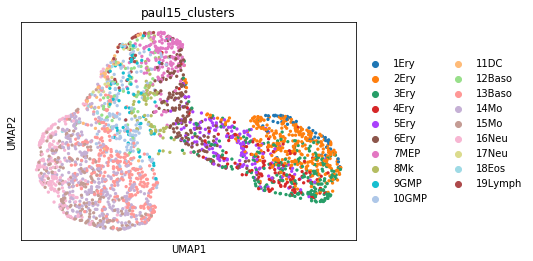

In [9]:
adata.X = adata.layers['VAE']
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pl.umap(adata, color='paul15_clusters')

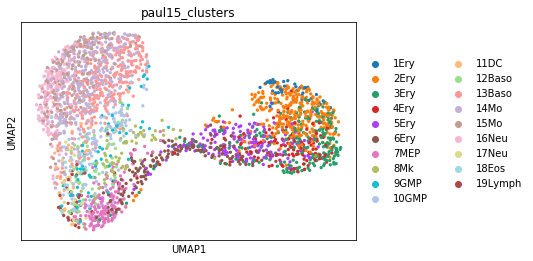

In [10]:
sc.pp.neighbors(adata, use_rep='X_vae_mean')
sc.tl.umap(adata)
sc.pl.umap(adata, color='paul15_clusters')

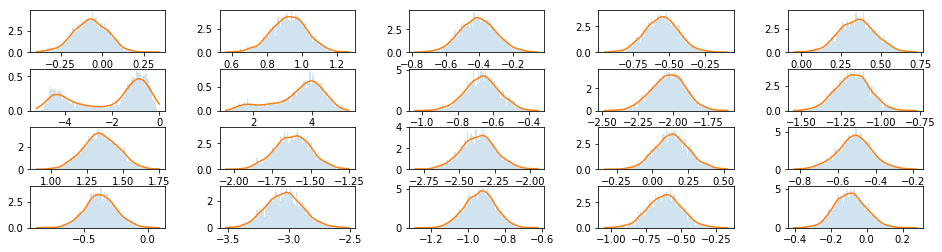

In [11]:
plot_marginals(adata)

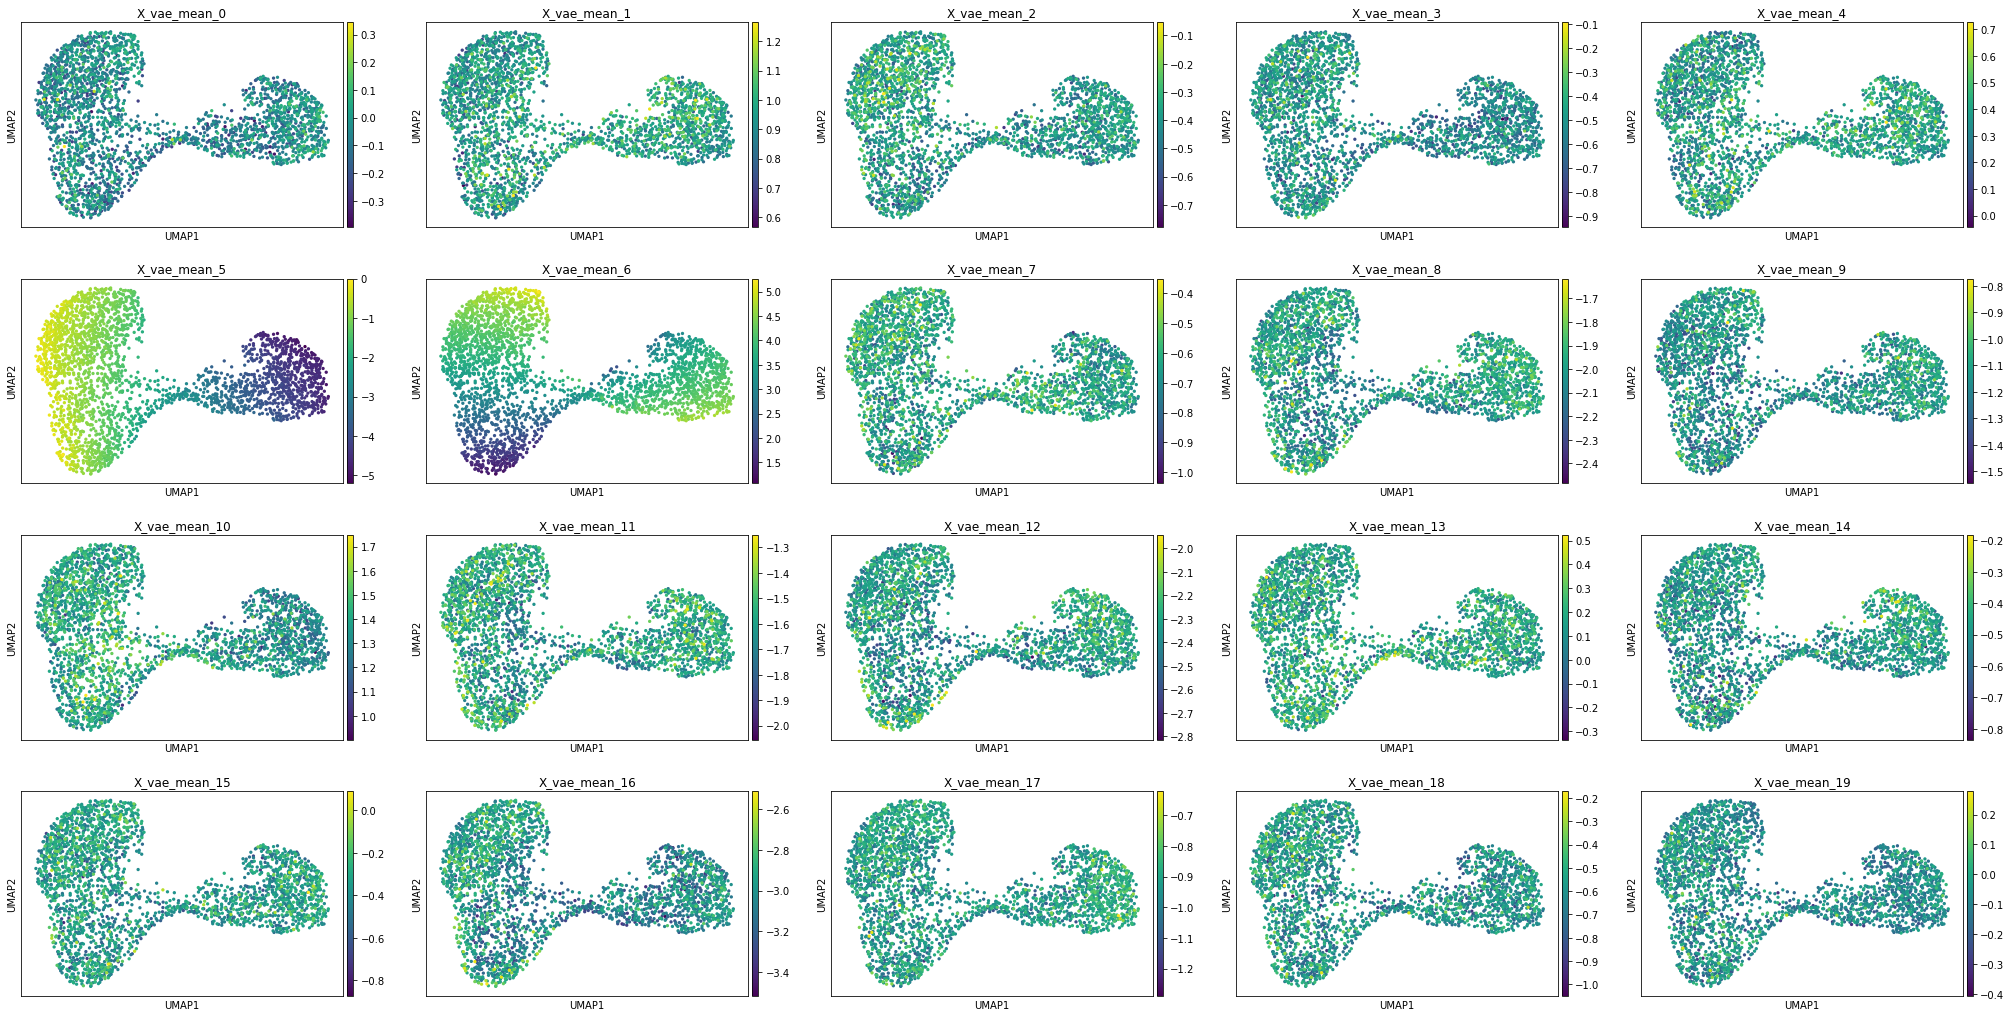

In [12]:
latent_dim = adata.obsm['X_vae_mean'].shape[1]

for i in range(latent_dim):
    adata.obs[f'X_vae_mean_{i}'] = adata.obsm['X_vae_mean'][:, i]
    
sc.pl.umap(adata, color=[f'X_vae_mean_{i}' for i in range(latent_dim)], ncols=5)

## PCA

In [13]:
sc.pp.pca(adata, n_comps=20)

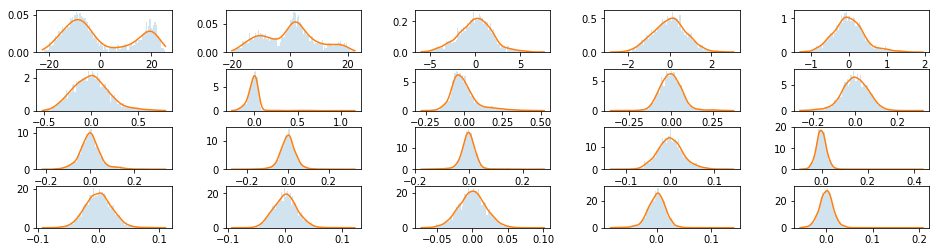

In [14]:
plot_marginals(adata, 'X_pca')

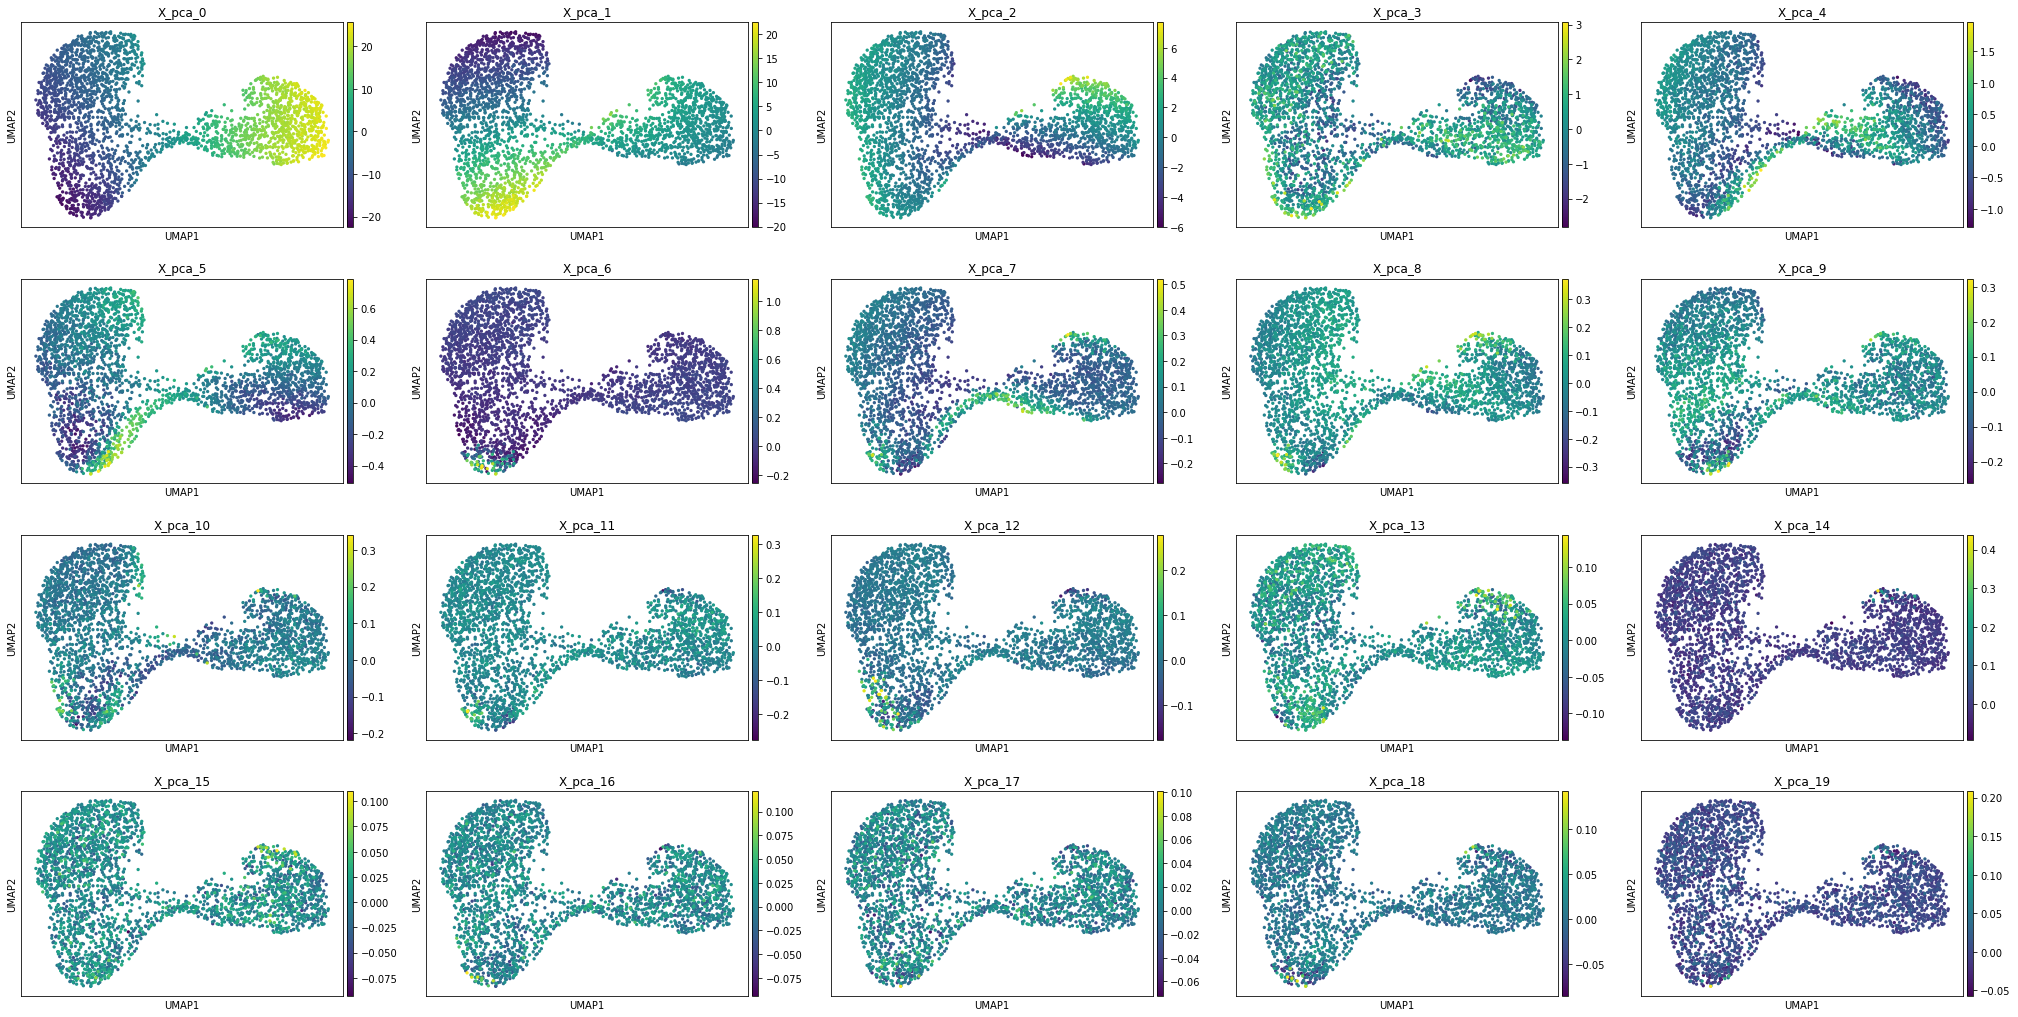

In [15]:
latent_dim = 20

for i in range(latent_dim):
    adata.obs[f'X_pca_{i}'] = adata.obsm['X_pca'][:, i]
    
sc.pl.umap(adata, color=[f'X_pca_{i}' for i in range(latent_dim)], ncols=5)

## Cond betaVAE

In [16]:
adata = sc.datasets.paul15()
sc.pp.normalize_total(adata, target_sum=10000)
sc.pp.log1p(adata)
adata

... storing 'paul15_clusters' as categorical
Trying to set attribute `.uns` of view, making a copy.


AnnData object with n_obs × n_vars = 2730 × 3451 
    obs: 'paul15_clusters'
    uns: 'iroot'

In [17]:
adata, model, trainer, loader = fit_single_cell(adata, 'paul15', categorical_vars=['paul15_clusters'], output_activation='softplus',
                                                unwanted_vars=['paul15_clusters'], epochs=100, num_layers=2, scale_factor=2.)

Directory single_cell_results/paul15 already exists. Archiving it to single_cell_results/paul15.zip


In [18]:
adata

AnnData object with n_obs × n_vars = 2730 × 3451 
    obs: 'paul15_clusters'
    uns: 'iroot'
    obsm: 'X_vae_samples', 'X_vae_mean', 'X_vae_var'
    layers: 'VAE', 'VAE_corrected'

In [19]:
model

CondVAEFC(
  (_encoder): EncoderFC(
    (fc_layers): ModuleList(
      (0): Linear(in_features=3451, out_features=256, bias=True)
      (1): Linear(in_features=256, out_features=256, bias=True)
    )
    (mu_logvar_gen): Linear(in_features=256, out_features=40, bias=True)
  )
  (_decoder): CondDecoderFC(
    (fc_layers): ModuleList(
      (0): Linear(in_features=39, out_features=256, bias=True)
      (1): Linear(in_features=256, out_features=256, bias=True)
    )
    (output_layer): Linear(in_features=256, out_features=3451, bias=True)
  )
)

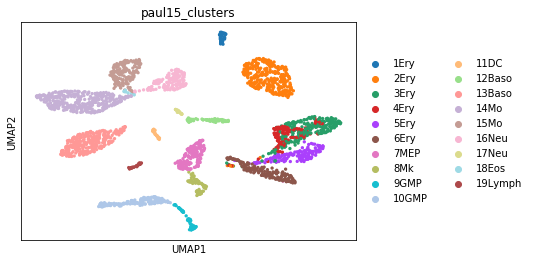

In [20]:
adata.X = adata.layers['VAE']
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pl.umap(adata, color='paul15_clusters')

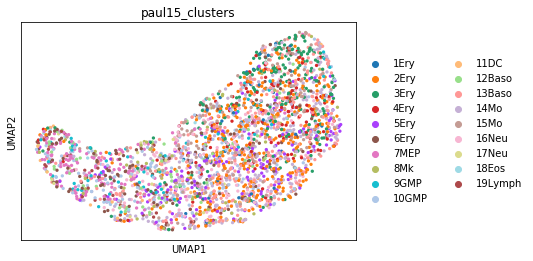

In [21]:
adata.X = adata.layers['VAE_corrected']
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pl.umap(adata, color='paul15_clusters')

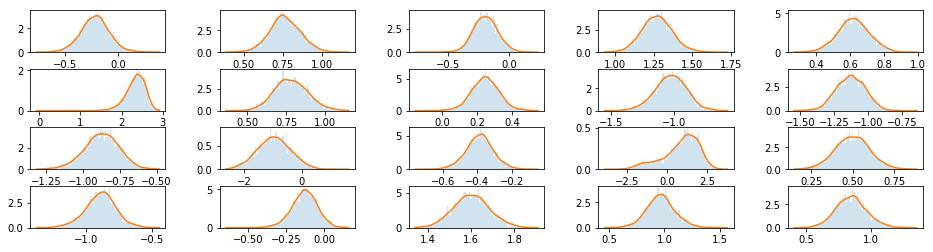

In [22]:
plot_marginals(adata)

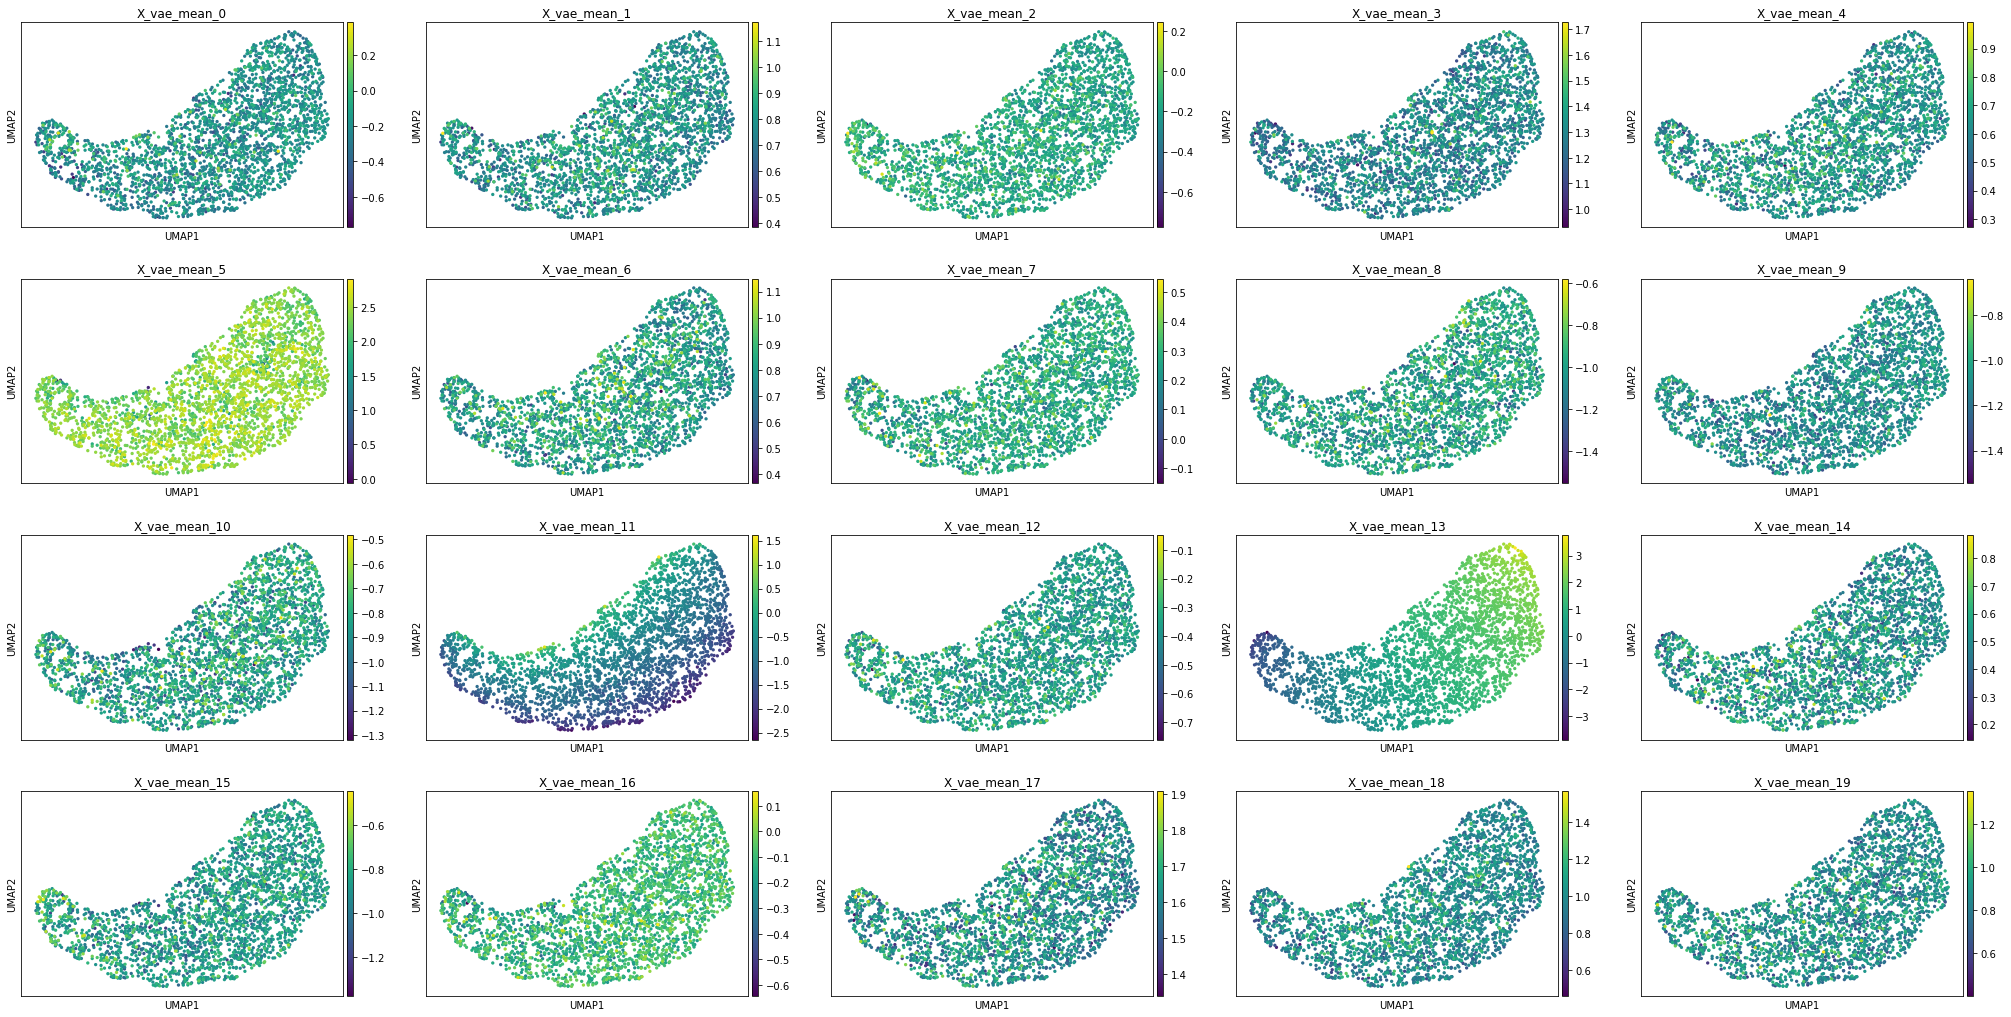

In [23]:
latent_dim = adata.obsm['X_vae_mean'].shape[1]

for i in range(latent_dim):
    adata.obs[f'X_vae_mean_{i}'] = adata.obsm['X_vae_mean'][:, i]
    
sc.pl.umap(adata, color=[f'X_vae_mean_{i}' for i in range(latent_dim)], ncols=5)